In [1]:
%load_ext autoreload

In [2]:
%autoreload

import sys
sys.path.append('..')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import color.data.dataset as color_dataset
import color.utils.utils as utils

In [3]:
# Get colors dataset
dataset = color_dataset.Dataset(dataset='small', emb_len=50, add_stop_word=False, normalize_rgb=True)

Loading colors dataset
Loading embeddings
Splitting dataset


In [6]:
class NamePredictorSequenceModel(nn.Module):
    
    def __init__(self, **kwargs):
        super(NamePredictorSequenceModel, self).__init__()
        
        # RNN model defaults
        self.params = {
            'name': 'rnn-name-predictor',  # Model name
            'model_type': 'RNN',  # One of (RNN, LSTM)
            'emb_dim': 50,  # Embedding dimensions
            'color_dim': 3,  # Color space dimensions, But don't change
            'hidden_dim': 50,  # No of neurons in each hidden layer
            'num_layers': 2,  # No of hidden layers
            'dropout': 0,  # Dropout factor
            'nonlinearity': 'relu'  # Only for RNN: Activation function: tanh, relu
        }
        utils.dict_update_existing(self.params, kwargs)

        # A linear layer converts RGB value to a vector of the same length as the embeddings
        self.rgb2emb = nn.Linear(self.params['color_dim'], self.params['emb_dim'])

        # RNN Layer
        if self.params['model_type'] == 'RNN':
            self.rnn = nn.RNN(
                self.params['emb_dim'], self.params['hidden_dim'], num_layers=self.params['num_layers'],
                dropout=self.params['dropout'], nonlinearity=self.params['nonlinearity']
            )
        else:
            self.rnn = nn.LSTM(
                self.params['emb_dim'], self.params['hidden_dim'],
                num_layers=self.params['num_layers'], dropout=self.params['dropout']
            )

        # Final linear layer converts RNN output to output embeddings
        self.hidden2emb = nn.Linear(self.params['hidden_dim'], self.params['emb_dim'])

    def forward(self, rgb, emb):
        # Linear layer resizes rgb vector
        rgb2emb_out = self.rgb2emb(rgb)
        rgb2emb_out = rgb2emb_out.reshape(1, *rgb2emb_out.shape)  # Reshape to a single sequence embedding

        # Prepare LSTM inputs
        # First time step input is the resized RGB vector, wheras the last word's embedding is not fed as input
        emb = torch.cat((rgb2emb_out, emb[:-1]), dim=0)

        # Process color name with RNN
        rnn_out, _ = self.rnn(emb)

        # Convert RNN output to output embedding
        return self.hidden2emb(rnn_out)

    def gen_name(self, rgb):
        """This function can be used as a co-routine to generate color name predictions"""

        # Linear layer resizes RGB vector
        rgb2emb_out = self.rgb2emb(rgb)
        rgb2emb_out = rgb2emb_out.reshape(1, *rgb2emb_out.shape)  # Reshape to a single sequence embedding

        # First time step - process transformed RGB vector
        rnn_out, rnn_state = self.rnn(rgb2emb_out)

        # The following co-routine works towards generating color names
        # At each iteration a new approximate word embedding is predicted and returned
        # An exact word embedding is received and the sequence processing continues
        while True:
            # Process RNN output with final linear layer and return the output embedding and RNN state
            # The received input is a tuples of computed word embedding and RNN state
            emb, rnn_state = yield self.hidden2emb(rnn_out), rnn_state

            # Process embedding with RNN
            rnn_out, rnn_state = self.rnn(emb, rnn_state)

In [7]:
m = NamePredictorSequenceModel()
print(utils.get_trainable_params(m))
rgb = torch.Tensor(32, 3)
emb = torch.Tensor(4, 32, 50)
m(rgb, emb).shape

12950


torch.Size([4, 32, 50])

In [8]:
# Model Training
num_epochs = 5
model = NamePredictorSequenceModel().double()
optimizer = torch.optim.SGD(model.parameters(), lr=0.07)
loss_fn = nn.MSELoss()
losses = []

# Initialize train loader
train_loader = color_dataset.DataLoader(
    dataset.train_set,
    seq_len_first=True,
    use_cuda = False
)

# Train
for epoch in range(num_epochs):
    tot_loss = 0
    for i, (rgb, embedding, _) in enumerate(train_loader):
        model.zero_grad()
        embedding_preds = model(rgb, embedding)
        loss = loss_fn(embedding, embedding_preds)
        loss.backward()
        tot_loss += loss.detach().numpy()
        optimizer.step()
    print('Epoch Complete : {}'.format(epoch+1))
    losses.append(tot_loss)

Epoch Complete : 1
Epoch Complete : 2
Epoch Complete : 3
Epoch Complete : 4
Epoch Complete : 5


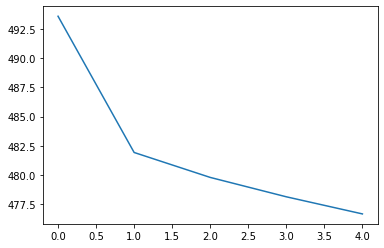

In [9]:
# Plot loss per epoch (should be going down)
losses = np.array(losses)
plt.plot(np.arange(len(losses)), losses)

In [11]:
# Compute norm of each embedding vector
embs = torch.DoubleTensor(dataset.embeddings)
embs_mag = torch.sqrt(torch.sum(embs*embs, dim=1)).reshape(-1)

In [12]:
class NamePrediction:
    
    def __init__(self, words, last_emb, similarity):
        self.words = words
        self.last_emb = last_emb
        self.similarity = similarity
        self.emb_pred = None
        self.nn_state = None

def predict_names(model, dataset, rgb, num_names=3, max_len=6, stop_word=False, normalize_rgb=True):
    """Predicts a number of names for the specified color RGB value"""
    
    # Covert RGB value to to input tensor and optionally normalize it
    rgb = torch.DoubleTensor(rgb).view(1, 3)
    if normalize_rgb:
        rgb = rgb / 256
    
    with torch.no_grad():
        
        # Create a generator instance
        name_generator = model.gen_name(rgb)
        
        # A list of selected word embeddings that will be sent to the generator
        # Before the first time step, no predictions exist
        predictions = [NamePrediction([], None, 0)]
        predictions[0].emb_pred, predictions[0].nn_state = next(name_generator)
        
        for i in range(max_len):
            
            pred_candidates = []
            for pred in predictions:
                
                # emb_pred = name_generator.send(next_emb).view(-1,1)
                emb_pred_mag = torch.sqrt(torch.sum(pred.emb_pred*pred.emb_pred))
                emb_dot = torch.mm(embs, pred.emb_pred.view(-1,1)).view(-1)
                embs_sim = emb_dot / (embs_mag * emb_pred_mag)
                
                _, top_idx = torch.topk(embs_sim, num_names)
                for idx in top_idx.tolist():
                    
                    curr_words = pred.words[:]
                    curr_words.append(dataset.vocab[idx])
                    
                    last_emb = embs[idx].view(1, 1, -1)
                    sim = (embs_sim[idx] + (len(pred.words)*pred.similarity)) / len(curr_words)
                    pred_candidates.append(NamePrediction(curr_words, last_emb, sim))
            
            pred_candidates.sort(key=lambda pred: pred.similarity, reverse=True)
            predictions = pred_candidates[:num_names]
            
            for pred in predictions:
                pred.emb_pred, pred.nn_state = name_generator.send((pred.last_emb, pred.nn_state))
        
        return predictions

predictions = predict_names(model, dataset, (0, 0, 0))
for i, pred in enumerate(predictions):
    print('Rank : {}\t-\t{}\t-\tSimilarity : {}'.format(
        i+1,
        ' '.join(pred.words),
        pred.similarity
    ))

Rank : 1	-	green small green small green small	-	Similarity : 0.8139081753249036
Rank : 2	-	green small green small green water	-	Similarity : 0.8119619799905703
Rank : 3	-	green small green small green little	-	Similarity : 0.8078149606886339
